# 1. Cài đặt thư viện

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta

# 2. Đọc và tiền xử lý dữ liệu

In [4]:
from google.colab import files
uploaded = files.upload()

Saving gold_price.csv to gold_price.csv


In [8]:
df = pd.read_csv("gold_price.csv")
df.columns = ["Date", "Price", "Open", "High", "Low", "Volume", "Change"]
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df = df.sort_values("Date").reset_index(drop=True)

for col in ["Price", "Open", "High", "Low"]:
    df[col] = df[col].str.replace(",", "").astype(float)
df["Volume"] = df["Volume"].str.replace("K", "").str.replace(",", "").astype(float) * 1_000
df["Change"] = df["Change"].str.replace("%", "").astype(float)


df.set_index("Date", inplace=True)

df.head()

,Price,Open,High,Low,Volume,Change
Date,,,,,,
2010-01-04,1118.3,1099.0,1124.6,1093.8,155480.0,2.02
2010-01-05,1118.7,1122.0,1129.6,1115.5,156410.0,0.04
2010-01-06,1136.5,1118.5,1141.0,1116.8,176900.0,1.59
2010-01-07,1133.7,1139.0,1139.5,1128.7,121150.0,-0.25
2010-01-08,1138.9,1131.5,1140.0,1119.5,212620.0,0.46


# 3. Kiểm tra tính dừng và sai phân

In [11]:
def check_stationarity(df):
    for col in df.columns:
        result = adfuller(df[col].dropna())
        print(f"{col}: p-value = {result[1]:.4f} {'(Stationary)' if result[1] < 0.05 else '(Non-stationary)'}")
print("Kiểm tra tính dừng của dữ liệu gốc:")
check_stationarity(df)

# Lấy sai phân để đảm bảo tính dừng
df_diff = df.diff().dropna()
print("\nKiểm tra tính dừng của dữ liệu sau sai phân:")
check_stationarity(df_diff)


Kiểm tra tính dừng của dữ liệu gốc:
Price: p-value = 0.9988 (Non-stationary)
Open: p-value = 0.9986 (Non-stationary)
High: p-value = 0.9988 (Non-stationary)
Low: p-value = 0.9984 (Non-stationary)
Volume: p-value = 0.0000 (Stationary)
Change: p-value = 0.0000 (Stationary)

Kiểm tra tính dừng của dữ liệu sau sai phân:
Price: p-value = 0.0000 (Stationary)
Open: p-value = 0.0000 (Stationary)
High: p-value = 0.0000 (Stationary)
Low: p-value = 0.0000 (Stationary)
Volume: p-value = 0.0000 (Stationary)
Change: p-value = 0.0000 (Stationary)


# 4. Chia tập train/val/test (70/15/15)



In [14]:
n = len(df_diff)
train_end = int(n * 0.7)
val_end = train_end + int(n * 0.15)

# Get dates from the index of df_diff
dates = df_diff.index

dates_train = dates[:train_end]
dates_val = dates[train_end:val_end]
dates_test = dates[val_end:]

train = df_diff.iloc[:train_end]
val = df_diff.iloc[train_end:val_end]
test = df_diff.iloc[val_end:]

# 5. Huấn luyện mô hình VAR (gộp train + val)

In [15]:
train_val = pd.concat([train, val])
model = VAR(train_val)
results = model.fit(maxlags=15, ic='aic')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# 6. Dự đoán trên tập test

In [16]:
lag_order = results.k_ar
forecast_input = train_val.values[-lag_order:]
forecast_steps = len(test)
forecast = results.forecast(y=forecast_input, steps=forecast_steps)

In [17]:
# Chuyển dự đoán sai phân về giá trị gốc
forecast_test_diff = pd.DataFrame(forecast, index=dates_test, columns=df.columns)
last_observed = df.loc[train_val.index][-1:]  # Giá trị gốc cuối cùng của train_val
forecast_test = forecast_test_diff.cumsum() + last_observed.values
forecast_test_df = pd.DataFrame(forecast_test, index=dates_test, columns=df.columns)

# 7. Đánh giá trên Price

In [19]:
def evaluate(y_true, y_pred, y_train_series):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    naive = np.abs(y_train_series[1:] - y_train_series[:-1])
    mase = mae / np.mean(naive)
    return rmse, mae, mape, mase

# Lấy giá trị gốc của test để đánh giá
test_original = df.loc[dates_test]
y_true = test_original['Price']
y_pred = forecast_test_df['Price']
y_train_original = df.loc[dates_train]['Price'].values
metrics_test = evaluate(y_true, y_pred, y_train_original)
print(f"Test: RMSE={metrics_test[0]:.4f}, MAE={metrics_test[1]:.4f}, MAPE={metrics_test[2]:.4f}, MASE={metrics_test[3]:.4f}")

Test: RMSE=488.9888, MAE=374.0770, MAPE=0.1505, MASE=37.4581


# 8. Dự báo tương lai 30/60/90 ngày

In [20]:
def forecast_future_VAR(model_result, last_data, steps, last_observed):
    forecast_vals = model_result.forecast(y=last_data.values[-model_result.k_ar:], steps=steps)
    forecast_index = pd.date_range(start=last_data.index[-1] + timedelta(days=1), periods=steps, freq='D')
    forecast_diff = pd.DataFrame(forecast_vals, index=forecast_index, columns=last_data.columns)
    forecast = forecast_diff.cumsum() + last_observed.values
    return pd.DataFrame(forecast, index=forecast_index, columns=last_data.columns)

In [21]:

last_observed = df.iloc[-1:]  # Giá trị gốc cuối cùng của toàn bộ dữ liệu
future_30_VAR = forecast_future_VAR(results, df_diff, 30, last_observed)
future_60_VAR = forecast_future_VAR(results, df_diff, 60, last_observed)
future_90_VAR = forecast_future_VAR(results, df_diff, 90, last_observed)

# 9. Vẽ biểu đồ kết quả

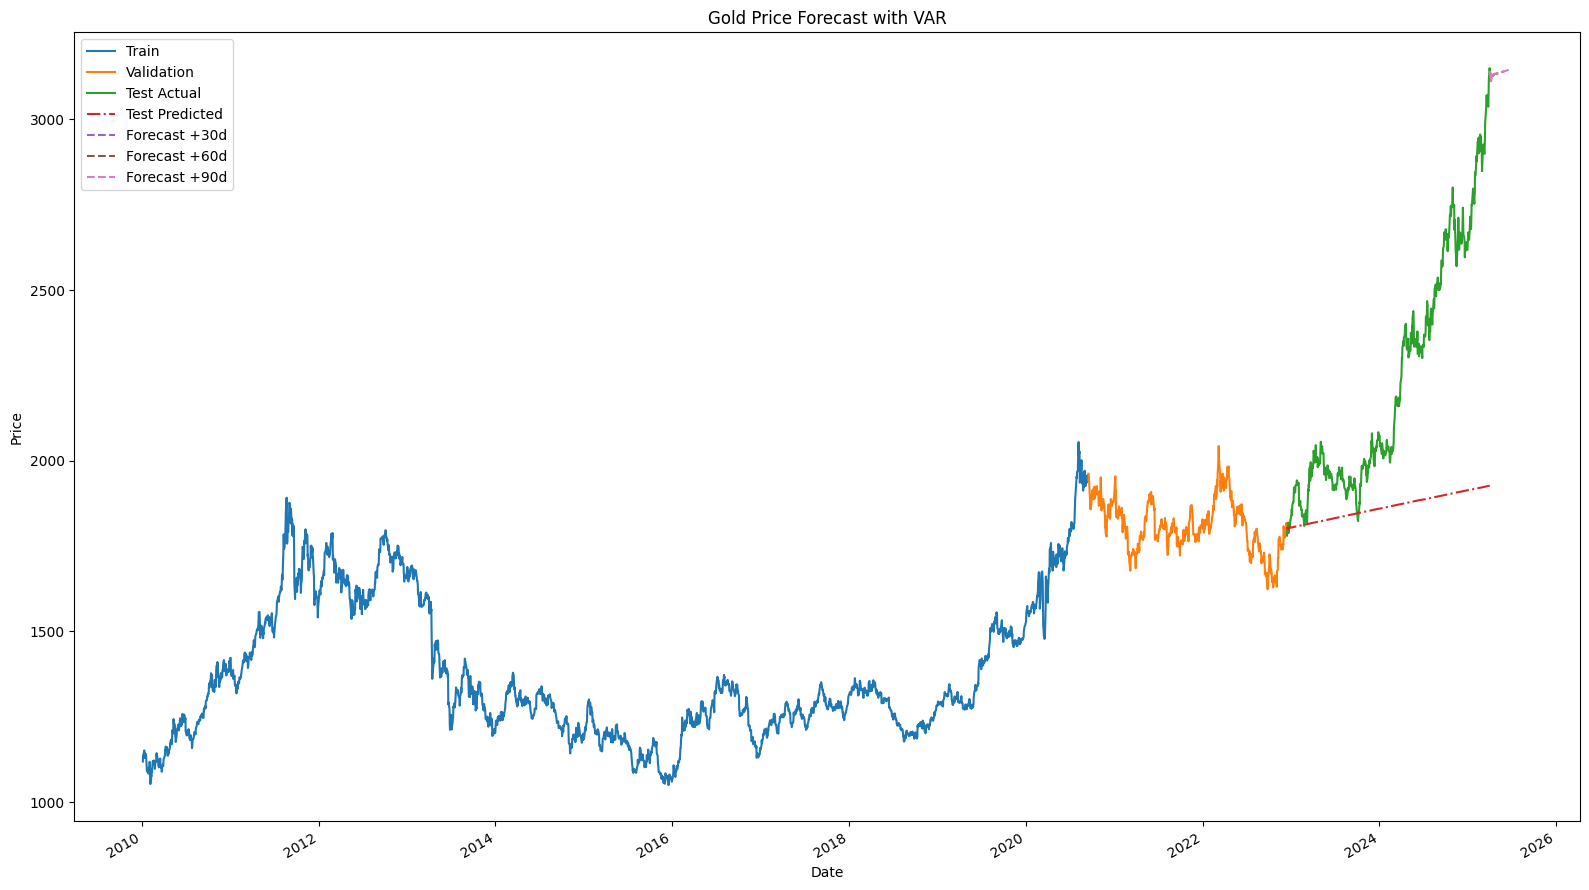

In [22]:
plt.figure(figsize=(16, 9))

# Plot train, validation, test actuals
plt.plot(dates_train, df.loc[dates_train]['Price'], label="Train")
plt.plot(dates_val, df.loc[dates_val]['Price'], label="Validation")
plt.plot(dates_test, df.loc[dates_test]['Price'], label="Test Actual")

# Plot test predictions
plt.plot(dates_test, forecast_test_df['Price'], label="Test Predicted", linestyle='-.')

# Plot future forecasts
plt.plot(future_30_VAR.index, future_30_VAR['Price'], label="Forecast +30d", linestyle='--')
plt.plot(future_60_VAR.index, future_60_VAR['Price'], label="Forecast +60d", linestyle='--')
plt.plot(future_90_VAR.index, future_90_VAR['Price'], label="Forecast +90d", linestyle='--')

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Gold Price Forecast with VAR")
plt.legend()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig('gold_price_forecast_var.png')
plt.show()